In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

In [249]:
df = pd.read_csv('data/full_incl_temp.csv')
print(df.shape, df.columns)
df['temp']= df['temp']-272
df['weekend'] = (df['datetimeDayofweek'] >4).astype(float)
df.head().T

(44566, 50) Index(['Logische Periode ', ' Endzeitstempel ', ' Status ', ' Tarif ',
       'location', 'adress', 'datetime', 'Wert', 'temp', 'temp_hamburg',
       'temp_dresden', 'temp_berlin', 'datetimeYear', 'datetimeMonth',
       'datetimeWeek', 'datetimeDay', 'datetimeDayofweek', 'datetimeDayofyear',
       'datetimeHour', 'datetimeMinute', 'datetimeSecond', 'datetimeElapsed',
       'lat', 'long', 'city', '48-lag', '24-lag', 'dif', 'temp.1', 'temp_min',
       'temp_max', 'pressure', 'sea_level', 'grnd_level', 'humidity',
       'wind_speed', 'wind_deg', 'rain_1h', 'rain_3h', 'rain_24h',
       'rain_today', 'snow_1h', 'snow_3h', 'snow_24h', 'snow_today',
       'clouds_all', 'weather_id', 'weather_main', 'weather_description',
       'weather_icon'],
      dtype='object')


,0,1,2,3,4
Logische Periode,08.01.2019,08.01.2019,08.01.2019,08.01.2019,08.01.2019
Endzeitstempel,07:00:00,07:00:00,07:00:00,07:00:00,07:00:00
Status,W,W,W,W,W
Tarif,tariflos,tariflos,tariflos,tariflos,tariflos
location,Joachim-Karnatz-Allee,Tharandter Str.,Lüttkamp,Flughafenstr.,Triftstr.
adress,"10725 Berlin, Joachim-Karnatz-Allee 43","Tharandter Str. 48, 01159 Dresden","22715 Hamburg, Lüttkamp 5","22583 Hamburg, Flughafenstr. 7412","13296 Berlin, Triftstr. 31"
datetime,2019-01-08 07:00:00,2019-01-08 07:00:00,2019-01-08 07:00:00,2019-01-08 07:00:00,2019-01-08 07:00:00
Wert,858.66,110.731,365.674,174.427,1191.33
temp,6.64,5.15,7.15,7.15,6.64
temp_hamburg,279.15,279.15,279.15,279.15,279.15


In [3]:
print(df.shape)
df = df[df['Wert']!=0]
print(df.shape)

(44566, 51)
(42976, 51)


In [4]:
df['48-lag'] = df['48-lag'].astype(float)
df['dif'] = df['dif'].astype(float)
df['Wert'] = df['Wert'].astype(float)
df['temp'] = df['temp'].astype(float)

In [140]:
cols = ['Wert', 'location', 'datetimeMonth', 
        'datetimeDayofweek', 'datetimeDayofyear', 'datetimeHour',
         'datetimeElapsed',  '48-lag','temp',
        'weekend',
        'city',
        'pressure',
        'wind_speed',
        'clouds_all',
        'humidity',
        'temp_min','temp_max'
       ]
cat_names = ['location','datetimeMonth','datetimeDayofweek','datetimeHour', 'city',
             'weather_main','weekend'
            ]
dep_var = 'Wert'
df_tab = df[cols]
df_tab[df_tab.isnull().any(axis=1)]
df_tab = pd.get_dummies(df_tab)
cols_dum = list(df_tab.columns) 
cols_dum.remove('Wert')

In [141]:
print(df_tab.shape)
df_tab = df_tab.dropna()
print(df_tab.shape)

(42976, 26)
(42540, 26)


In [217]:
set(df_tab.datetimeDayofweek)

{0, 1, 2, 3, 4, 5, 6}

In [234]:
test_idx = [idx for idx,day in zip(range(len(df_tab)),df_tab.datetimeDayofweek) if (
    ( day == 6 &(np.random.rand()<.3)) 
    or
    ( day == 2&(np.random.rand()<.3) )
    or
    ( day == 5&(np.random.rand()<.3) )
)] 
valid_idx = [idx for idx in range(len(df_tab)) if (np.random.rand()<float(.25)) & (idx not in test_idx)] 
train_idx = [idx for idx in range(len(df_tab)) if (idx not in valid_idx)& (idx not in test_idx)]

In [235]:
print(len(valid_idx), len(df_tab), len(test_idx)/len(df_tab), len(valid_idx)/len(df_tab),len(train_idx)/len(df_tab))

8590 42540 0.18236953455571228 0.20192759755524212 0.6157028678890456


In [236]:
df_tab.iloc[train_idx,:].tail()

,Wert,datetimeMonth,datetimeDayofweek,datetimeDayofyear,datetimeHour,datetimeElapsed,48-lag,temp,weekend,pressure,...,location_Flughafenstr.,location_Joachim-Karnatz-Allee,location_Lüttkamp,location_Ochsenweberstr.,location_Tharandter Str.,location_Triftstr.,location_Wilhelmsburger Str.,city_Berlin Tempelhof,city_Hamburg Fuhlsbuettel,city_Oschatz
44561,41.558,9,3,248,2,1567648800,94.037,15.43,0.0,1010,...,0,0,1,0,0,0,0,0,1,0
44562,168.401,9,3,248,3,1567652400,72.174,14.50,0.0,1010,...,0,0,1,0,0,0,0,0,1,0
44563,41.558,9,3,248,4,1567656000,172.772,13.74,0.0,1010,...,0,0,1,0,0,0,0,0,1,0
44564,162.935,9,3,248,5,1567659600,32.806,12.94,0.0,1011,...,0,0,1,0,0,0,0,0,1,0
44565,49.204,9,3,248,6,1567663200,95.132,12.52,0.0,1010,...,0,0,1,0,0,0,0,0,1,0


In [237]:
xgtrain = xgb.DMatrix(df_tab.iloc[train_idx,:][cols_dum].values, df_tab.iloc[train_idx,:].Wert.values, feature_names=cols_dum)
xgvalid = xgb.DMatrix(df_tab.iloc[valid_idx][cols_dum].values, df_tab.iloc[valid_idx,:].Wert.values, feature_names=cols_dum)
xgtest = xgb.DMatrix(df_tab.iloc[test_idx][cols_dum].values, feature_names=cols_dum)

In [245]:
param = {'eta':.25,'gamma':1,'max_depth':7, 'objective':'reg:squarederror', 'verbose':3 ,'eval_metric':'mae'}
num_round = 1000
bst = xgb.train(param, xgtrain, num_round, verbose_eval=True, early_stopping_rounds=10,evals=[(xgvalid,'valid')])
# # make prediction
preds_train = bst.predict(xgtrain)
preds_val = bst.predict(xgvalid)
preds_test = bst.predict(xgtest)

bst

[0]	valid-mae:561.941
Will train until valid-mae hasn't improved in 10 rounds.
[1]	valid-mae:425.089
[2]	valid-mae:324.265
[3]	valid-mae:249.923
[4]	valid-mae:194.959
[5]	valid-mae:155.568
[6]	valid-mae:127.265
[7]	valid-mae:107.409
[8]	valid-mae:93.2533
[9]	valid-mae:83.6813
[10]	valid-mae:76.7983
[11]	valid-mae:71.9029
[12]	valid-mae:68.9329
[13]	valid-mae:66.7192
[14]	valid-mae:65.3055
[15]	valid-mae:64.2995
[16]	valid-mae:63.2328
[17]	valid-mae:62.3779
[18]	valid-mae:61.5605
[19]	valid-mae:60.7958
[20]	valid-mae:60.0921
[21]	valid-mae:59.5319
[22]	valid-mae:59.4191
[23]	valid-mae:58.9196
[24]	valid-mae:58.7904
[25]	valid-mae:58.6805
[26]	valid-mae:58.4876
[27]	valid-mae:58.3675
[28]	valid-mae:58.1279
[29]	valid-mae:58.046
[30]	valid-mae:57.807
[31]	valid-mae:57.6649
[32]	valid-mae:57.5374
[33]	valid-mae:57.491
[34]	valid-mae:57.0094
[35]	valid-mae:56.7841
[36]	valid-mae:56.5876
[37]	valid-mae:56.5387
[38]	valid-mae:56.4126
[39]	valid-mae:56.2953
[40]	valid-mae:56.2075
[41]	valid-ma

In [246]:
print(np.mean(abs(preds_train-df_tab.iloc[train_idx,:].Wert.values)))
print(np.mean(abs(preds_val-df_tab.iloc[valid_idx,:].Wert.values)))
print(np.mean(abs(preds_test-df_tab.iloc[test_idx,:].Wert.values)))
print(100-(np.mean(abs(preds_test-df_tab.iloc[test_idx,:].Wert.values))/np.mean(abs(df_tab.iloc[test_idx,:]['48-lag']-df_tab.iloc[test_idx,:].Wert)))*100)

17.21526020600485
48.96190675281171
69.07453880785307
39.12076223737484


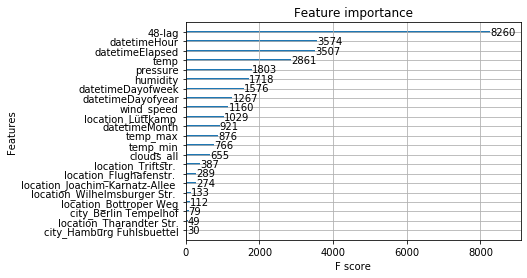

In [251]:
xgb.plot_importance(bst)

In [174]:
bst.save_model('xgboost_try.model')

In [247]:
set(df['datetimeMonth'])

{1, 2, 3, 4, 5, 6, 7, 8, 9}

In [250]:
df[df['datetimeMonth'] == 6].Wert.sum()

1891532.227

epoch,train_loss,valid_loss,mean_absolute_error,root_mean_squared_error,time
0,68297.703125,22874.908203,84.260231,140.070740,00:05


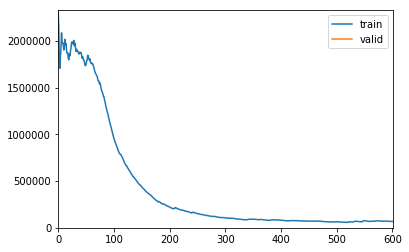

In [103]:
learn.fit_one_cycle(1,.05)

In [104]:
learn.validate()

[22874.908, tensor(84.2602), tensor(140.0707)]

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


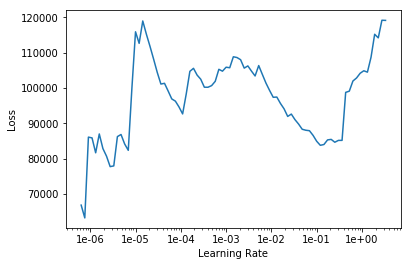

In [79]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,mean_absolute_error,root_mean_squared_error,time
0,86165.429688,29965.220703,96.175285,155.561325,00:06
1,76595.843750,29469.826172,91.801399,152.935928,00:06
2,86682.718750,34316.460938,107.844551,167.129730,00:06


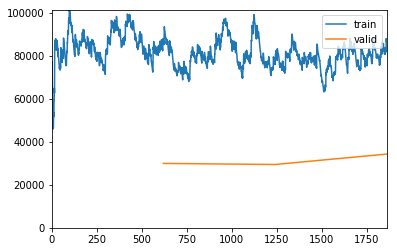

In [80]:
learn.fit(3,1e-5)

In [74]:
learn.validate()

[23191.447, tensor(82.6168), tensor(137.5023)]

In [105]:
learn.save('new_data_weekend_wo_0')

In [83]:
learn.load('new_data_weekend');

In [290]:
np.log(df.dif+5).mean()

3.853784062949676

In [115]:
100-(learn.validate()[1]/df.dif.mean()).numpy()*100

23.430657386779785

In [36]:
100-(79.5499/95.44201567656432)*100

16.65106878130051

In [106]:
df_pred = df.loc[:,cols].dropna()
datatest = TabularList.from_df(df_pred, cat_names=cat_names,  procs=procs)
learn.data.add_test(datatest) 
# # print(learn.data)
preds, targets = learn.get_preds(DatasetType.Test)

tensor(695.5474) tensor(1128.7273)


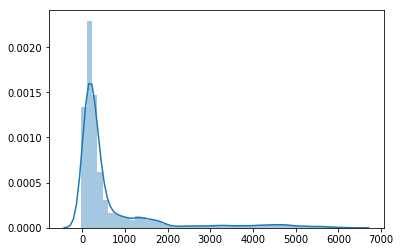

In [85]:
print(preds[:,0].mean(), preds[:,0].std())
sns.distplot(list(preds[:,0]))

In [107]:
df_pred['predicted'] = preds[:,0].numpy()
df_pred['predicted'].mean(), df_pred['predicted'].std()

(727.133544921875, 1148.5184326171875)

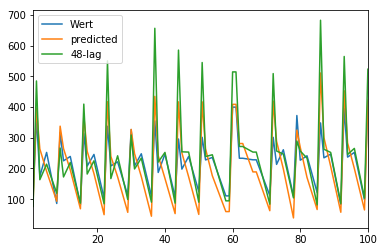

In [108]:
df_pred.loc[:100,['Wert','predicted','48-lag']].plot()

In [109]:
df_pred['dif_tako_abs'] = abs(df_pred['predicted'] - df_pred['Wert'])
df_pred['dif_guido_abs'] = abs(df_pred['48-lag'] - df_pred['Wert'])
df_pred['dif_tako'] = df_pred['predicted'] - df_pred['Wert']
df_pred['dif_guido'] = df_pred['48-lag'] - df_pred['Wert']
print(df_pred['dif_tako_abs'].mean(),df_pred['dif_guido_abs'].mean(),100*(1-df_pred['dif_tako_abs'].mean()/df_pred['dif_guido_abs'].mean()))

85.71657679886235 110.04433862247333 22.107236163299316


In [110]:
df_pred.to_csv('predicted_new_data_weekend_wo_0.csv',index=False)

In [111]:
def get_long(val):
    # 5 = 755 - 750
    a = val['pred'] - val['target']
    if a > 0:
        return a
    return 0

def get_short(val):
    # -5 = 750 - 755
    a = val['pred'] - val['target']
    if a < 0:
        return -a
    return 0

def sep_long_short(df,pred='predicted',target='Wert'):
    df_ = df.rename(columns={pred:'pred',target:'target'})
    df_['long'] = df_[['pred','target']].apply(get_long,1)
    df_['short'] = df_[['pred','target']].apply(get_short,1)
    return df_[['long','short']]

df_pred[['long_tako','short_tako']] =sep_long_short(df_pred,'predicted')
df_pred[['long_48','short_48']] =sep_long_short(df_pred,'48-lag')

In [91]:
df_pred.head().T

,1,2,3,5,8
Wert,110.731,365.674,174.427,252.154,86.006
location,Tharandter Str.,Lüttkamp,Flughafenstr.,Wilhelmsburger Str.,Tharandter Str.
datetimeMonth,1,1,1,1,1
datetimeDayofweek,1,1,1,1,1
datetimeDayofyear,8,8,8,8,8
datetimeHour,7,7,7,7,8
datetimeElapsed,1546930800,1546930800,1546930800,1546930800,1546934400
48-lag,76.328,484.66,163.402,213.95,119.331
temp,5.15,7.15,7.15,7.15,5.15
weekend,0,0,0,0,0


In [112]:
df_day = df_pred.groupby(['datetimeDayofyear','location']).sum()
df_day.head().T

datetimeDayofyear               3              4                \
location          Tharandter Str. Flughafenstr.      Lüttkamp    
Wert                 1.756711e+03   7.618476e+03  1.790382e+04   
datetimeMonth        1.700000e+01   3.500000e+01  3.500000e+01   
datetimeDayofweek    5.100000e+01   1.400000e+02  1.400000e+02   
datetimeHour         2.550000e+02   4.590000e+02  4.590000e+02   
datetimeElapsed      2.629097e+10   5.413125e+10  5.413125e+10   
48-lag               1.306243e+03   7.346644e+03  1.539870e+04   
temp                -8.450000e+00   2.012200e+02  2.012200e+02   
weekend              0.000000e+00   0.000000e+00  0.000000e+00   
pressure             1.752400e+04   3.598600e+04  3.598600e+04   
wind_speed           7.400000e+01   1.980000e+02  1.980000e+02   
predicted            1.331685e+03   9.386725e+03  1.363234e+04   
dif_tako_abs         4.250263e+02   1.768281e+03  6.198545e+03   
dif_guido_abs        4.504680e+02   5.508620e+02  7.078707e+03   
dif_tako            -4.250263e+02   1.768249e+03 -4.271473e+03   
dif_guido           -4.504680e+02  -2.718320e+02 -2.505113e+03   
long_tako            0.000000e+00   1.768265e+03  9.635360e+02   
short_tako           4.250263e+02   1.597876e-02  5.235009e+03   
long_48              0.000000e+00   1.395150e+02  2.286797e+03   
short_48             4.504680e+02   4.113470e+02  4.791910e+03   

datetimeDayofyear                                       
location          Tharandter Str. Wilhelmsburger Str.   
Wert                 4.093942e+03         8.462946e+03  
datetimeMonth        4.200000e+01         3.500000e+01  
datetimeDayofweek    1.680000e+02         1.400000e+02  
datetimeHour         4.800000e+02         4.590000e+02  
datetimeElapsed      6.495725e+10         5.413125e+10  
48-lag               3.790834e+03         8.178035e+03  
temp                 2.130000e+01         2.012200e+02  
weekend              0.000000e+00         0.000000e+00  
pressure             4.319400e+04         3.598600e+04  
wind_speed           1.690000e+02         1.980000e+02  
predicted            3.391476e+03         6.647339e+03  
dif_tako_abs         8.365410e+02         1.815607e+03  
dif_guido_abs        5.804840e+02         4.508730e+02  
dif_tako            -7.024660e+02        -1.815607e+03  
dif_guido           -3.031080e+02        -2.849110e+02  
long_tako            6.703753e+01         0.000000e+00  
short_tako           7.695035e+02         1.815607e+03  
long_48              1.386880e+02         8.298100e+01  
short_48             4.417960e+02         3.678920e+02

In [113]:
df_day.columns

Index(['Wert', 'datetimeMonth', 'datetimeDayofweek', 'datetimeHour',
       'datetimeElapsed', '48-lag', 'temp', 'weekend', 'pressure',
       'wind_speed', 'predicted', 'dif_tako_abs', 'dif_guido_abs', 'dif_tako',
       'dif_guido', 'long_tako', 'short_tako', 'long_48', 'short_48'],
      dtype='object')

In [114]:
df_day[['Wert', '48-lag', 'temp', 'predicted', 'dif_tako',
       'dif_guido', 'long_tako', 'short_tako', 'long_48', 'short_48',
       'dif_tako_abs', 'dif_guido_abs']].mean()

Wert             18688.798688
48-lag           18717.322225
temp               322.959589
predicted        18511.180735
dif_tako          -177.617966
dif_guido           28.523537
long_tako         1002.269167
short_tako        1179.887133
long_48           1415.005684
short_48          1386.482147
dif_tako_abs      2182.156300
dif_guido_abs     2801.487831
dtype: float64

In [79]:
a/1000000

98.68178866266666